## IMPORTS

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install mne

     |████████████████████████████████| 6.8MB 4.4MB/s 


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import mne
from mne.datasets.sleep_physionet.age import fetch_data

import keras
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, LeakyReLU, Flatten, Reshape, Activation, Dropout, Add, TimeDistributed, Multiply, Conv1D, UpSampling1D, Conv2D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History, ModelCheckpoint, LearningRateScheduler, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

## DATASET PREPROCESSING

In [4]:
def build_dataset(no_of_people=30):
  dataset = {'x': [], 'y':[]}
  people = [i for i in range(no_of_people)]
  remove_people = [36, 39, 52, 68, 69, 78, 79]
  for j in remove_people:
    try:
      people.remove(j)
    except ValueError:
      pass

  sf = 100
  annotation_desc_2_event_id = {'Sleep stage W': 1}
  event_id = {'Sleep stage W': 1}
  
  tmax = 30. - 1. / sf
  
  files = fetch_data(subjects=people, recording=[1])
  
  count = 0
        
  for file in files:
    temp_X = []
    temp_Y = []  
    raw = mne.io.read_raw_edf(file[0])
    annot = mne.read_annotations(file[1])
    raw.set_annotations(annot, emit_warning=False)
    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id, chunk_duration=30.)
    epochs = mne.Epochs(raw=raw, events=events,
                              event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    print("Subject No: ", count)
    count += 1
    if count == 1:
      x = (epochs.get_data(picks="eeg"))[:,0,:]
      y = epochs.events[:, 2]
      for i in range(y.shape[0]):
        if y[i] == 1:
          temp_Y.append(count)
          temp_X.append(x[i,:])
      X = np.array(temp_X)
      Y = np.array(temp_Y)
      
    else:
      x = (epochs.get_data(picks="eeg"))[:,0,:]
      y = epochs.events[:, 2]
      for i in range(y.shape[0]):
        if y[i] == 1:
          temp_Y.append(count)
          temp_X.append(x[i,:])
      X = np.concatenate((X, np.array(temp_X)), axis=0)
      Y = np.concatenate((Y, np.array(temp_Y)), axis=0)
      
  #X = (epochs_test.get_data(picks="eeg"))[:,0,:]
  #Y = epochs_test.events[:, 2]
  dataset['x'] = X
  dataset['y'] = Y
  return dataset

In [5]:
def normalize_vector(vector):
  normalized_vector = (vector - vector.min()) / (vector.max() - vector.min())
  return normalized_vector

In [6]:
dataset = build_dataset(60)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data



Verifying hash adabd3b01fc7bb75c523a974f38ee3ae4e57b40f.



Verifying hash 21c998eadc8b1e3ea6727d3585186b8f76e7e70b.



Verifying hash 4d17451f7847355bcab17584de05e7e1df58c660.



Verifying hash d582a3cbe2db481a362af890bc5a2f5ca7c878dc.



Verifying hash 8b135afa7fb93bb5f1998fda50355944777c245e.



Verifying hash 91043cfe46695088b17b6a02937b25efd674c3fb.



Verifying hash 85e58dc1e3303537dade8c5827ab58328239c384.



Verifying hash 6363d8b0fdc48cf396c9abf054bb4a9696d38bdb.



Verifying hash 04d2b88d25f2ae4a65ba44cd9145bd12800a0e20.



Verifying hash f148821669bd3588187b3b430bd79adf569f86d1.



Verifying hash ea073451b65ce8a6f1a02a8cc2b89d1a162ca0ae.



Verifying hash 4159ef8a3e119d6dcc1bede806f6fbc017b27a0f.



Verifying hash 1736736e585807c14f1ae8bc87a94cae222c5170.



Verifying hash 4bf99622c67c281b25ceccd35e7050328a2946e8.



Verifying hash 1374b34f6139b6ff7e865d8243eef39ba334ef50.



Verifying hash 608024fd19a140ad233a4680e07c2495a74b69c2.



Verifying hash 0e1cc2c4e1da14ab94515e3e7e75e8ad30ec99cb.



Verifying hash 9ec663ffa5c17afcaca59d7829d77b9165102237.



Verifying hash b3502e0bd54683e973182c791aa962b804e79633.



Verifying hash 7aa63b408c769a4a983a908b6ba41d87dd743c6e.



Verifying hash 3ae168ff2c9c0c56f51205fdb10f05a4c6b2064e.



Verifying hash 60d9c3913881e11b06ad99e9870bd1ca4d93c952.



Verifying hash e490956b4dce01c46ba88a2b847f091bb54ea16e.



Verifying hash 12db1920e2f6083c8ab1f2c24fe35dfa03715e4a.



Verifying hash 33c72025a7a215ea5e255f4254cb0f93b1313369.



Verifying hash daa57ece807cb5325c6d1ce059f0e8a8d1c85391.



Verifying hash 42ff97035aae6dd34ca9437857c48ac6f2ab97df.



Verifying hash 5beef85170bdbb5cf2eea24a79f0f5c2c3975c4b.



Verifying hash 83493e1c32d441c9e5ee3de6a024bfb5e7ab9f5f.



Verifying hash 511d398f22b9b2b304de27c40740a41584ff6af2.



Verifying hash 5a92d49699d4de369d66d9462e91b0dcb3312649.



Verifying hash 37dcbd339c95322d028b3a5466812697041cc373.



Verifying hash e56ff3aa366fe9a04a0fdfdd4cd862e77e8ac807.



Verifying hash 56711b1bfed292032491f5cce57494629286a131.



Verifying hash f1a65522cb7d6c71ac47742535a12c88e2019dad.



Verifying hash dd257c8d922f08c2c8ca5236c9bf54da887c68e5.



Verifying hash 23674d20572853eb6d988d24378c52123f66500c.



Verifying hash 51fc3df2df7d4da654f3e18ed1b233d0c60cfa80.



Verifying hash d6da621dbb20dec3494a38c7d2a0363793ac5ebe.



Verifying hash defc7b9368c2d3c4ab4a294757843825a83cdb5d.



Verifying hash 38a0be6e45ddd9b1f17d09964a32e005dc5a6519.



Verifying hash 83822f9970d3959ad2e0613492ae39bd0fae6068.



Verifying hash c106ad072dbc975a3742f7eff151219870f0c794.



Verifying hash 9126937ea8a414d6ae9bc4a4194d841a891fa8a8.



Verifying hash 8733ea022d3778259a436507156cf3360ad8be06.



Verifying hash b158eda4f81772095c129be77f8e60ec9d81b884.



Verifying hash d96f1f35b2f77c7de706036c6e4114139e07b307.



Verifying hash 9f6df70676d6cddcf069ceb7f408a7989af99ce2.



Verifying hash 58719e53fe18d2fc4cb1776ab5d43306beb1325d.



Verifying hash fb1432e303a8f99a2256ce682db95d88772c479f.



Verifying hash 7dbc0289707ff70662d367d65de7bec188484d1b.



Verifying hash e38be8134e4a36eb418ca1f06a1fe02b52d0ebf1.



Verifying hash b81c9bd1875b33713b5eb56b58f1e120841b507f.



Verifying hash 501eda59557bb99d530d01bdad3579f1e1158991.



Verifying hash 20994715d34edb26113180ee330ce287dbf57b60.



Verifying hash 26c5c7f3a5c350d3505af2857835ce81252c5990.



Verifying hash 51811913d7854f95c319076e670d988687ca667c.



Verifying hash d188150831e912081dbeda2695231177200c39f9.



Verifying hash f81c7574a5e5829e006d0b705bf5208a3349c9c7.



Verifying hash 577c1345f6d070d975db5016048722f78b1b414e.



Verifying hash 7818e5a02afa89e913111d91ecd651aa3e786e5d.



Verifying hash d49df84bfea28bb241c09b922cd2dc64f57c5ae5.



Verifying hash b62f5104bddf452f4700c85997e51bec17f0243b.



Verifying hash 812c34844e834b97949019741fa7f835d973725d.



Verifying hash 335381ae310e9f1f053c37763eeee74d7d873471.



Verifying hash 67ba7d3b97354deb31db095e748ea3a4014fae2c.



Verifying hash f37cb4df27286e38c604cae943169ff29b1473fc.



Verifying hash ca943e2b73c6404f929c372ebd817b7b3b71b4dd.



Verifying hash 17de25c8f023fe632aa403a6d9525c1cde8eaef5.



Verifying hash 81ba3c0d8320c9ee306f678b4bc9e6e266165886.



Verifying hash 631900bef36d359a0f5807a7e1b202f80b0427ac.



Verifying hash a15cdf3973b77198d8276dc505dbb35cb39a9b4a.



Verifying hash 0dc56fce13b6317f197d0b17c04f5be4af1c964f.



Verifying hash c19b6cbfdf3a33169ce9b4a5dc94f93b696a21ba.



Verifying hash 6098d2b501b82ca0ddc8893547c6990e204e8ba6.



Verifying hash fdbf653a4a675843c97d0a76ef5e4cebf5d2dbcb.



Verifying hash 28fd8ad1aee307847e2eb579763ebca18e56f540.



Verifying hash 65b5671a89871351ee3da7ea800aad276a445b2a.



Verifying hash 30a533b67fdb2adac6a4e83088a07fe1bbaddb6c.



Verifying hash 5df1bf20d4f29b95a2bdde853b2a157dd9530a8a.



Verifying hash e8a5d9e0f160ae7bd0b35d75d77b4c872daa30f8.



Verifying hash d2e34f9bcaac7af23da4448f742ac6ea3c895ed9.



Verifying hash 194ae942cf80764e81b4cdabeed9e5a57916aab3.



Verifying hash 497ad7e671edab6e7adc9d35a6aa45b7fd9a706b.



Verifying hash e3a09d832cb79b0095d7a311ef1b6ed7c569b79d.



Verifying hash 68d4e44ad54069701972df66d8a81b4ca434bf2f.



Verifying hash 315db0f9d91988ddc2b198f89cc22f96190eff71.



Verifying hash bc1f755c3367e378091c44481948a72fc7a928e5.



Verifying hash e4295014c6d4474d8f7f7792c2ea088eb9e43e9f.



Verifying hash 8980e770e58e5704bd36124f6b6bd8d5e3506e12.



Verifying hash 05d71b55de4c86791195391b1cec8b35e447922d.



Verifying hash ee235454dbfe947432f3f813c9a6384f6e42d36a.



Verifying hash c15f6a0e1802dcf74ecec41745677a4932375faf.



Verifying hash 50fce6396aceaf35d9d7e16175053a3b78f214d0.



Verifying hash 23ea1f5f299c6cd99d434f014d7490621dbbc854.



Verifying hash 36c6c8112524c7bc9553db37601b38984946209b.



Verifying hash 1c31fc02412029bc7369979b8c9f5956420748f5.



Verifying hash eb2621c1670a42eb38dfa86a9bc3326818365f3d.



Verifying hash e12eb259c2894d45b8d0b2f0e75810c2de02237d.



Verifying hash e549275e9182b9e36ade5abb721098e235ecb164.



Verifying hash 71222ac5b7784ed1d3a79ee3e9036431d6eba9bd.



Verifying hash 934dbfeb29f4f4db4b61e36fb8ddab4ddbf4ff94.



Verifying hash 4d3ec2f85149bb10fed1013831c3aa1f58049229.



Verifying hash a301385e6fbde02c83f2545f17cdf75d594d37ce.



Verifying hash 0bf97e463cbcefb7df48bca712f29dcc74223330.



Verifying hash e50b44e6b049baaeb528c31563642b2a2b933834.



Verifying hash 1a9baf1b072ca9d2784a404292169ff3177ea83f.



Verifying hash b31a2dfe652508df46f6afe03ab904c333f7b818.



Verifying hash e67f3bd381ddfb96d584f6c6d6f6762087d6553d.



Verifying hash 08ee39eb94d819968512297ca883f9bca046de9c.



Verifying hash 16a1edbd6a089386fd7de72aef802182d0a2959d.



Verifying hash bfc729575cfdf5f409be2de47dad4e00d43195bf.



Verifying hash 017793b040df8a860df0e43e3e0a496e2cb3f9c1.



Verifying hash f3bb949a7f82acb7fd3d8f35e92efee1402a383f.
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage W']
Not setting metadata
Not setting metadata
1997 matching events found
No baseline correction applied
0 projection items activated
Subject No:  0
Loading data for 1997 events and 3000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage W']
Not setting metadata
Not setting metadata
1856 matching events found
No baseline correction applied
0 projection items activated
Subject No:  1
Loading data for 1856 events and 3000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /root/mne_data/ph

In [7]:
def preprocess_dataset(dataset, test_size=0.1, val_size=0.2):
  x = np.array([normalize_vector(i) for i in dataset['x']], dtype=np.float)
  x = np.reshape(x, (x.shape[0], x.shape[1], 1))
  y = np.array(dataset['y'], dtype=np.uint8)

  # ohe = OneHotEncoder()
  # y = ohe.fit_transform(y.reshape((-1,1))).toarray()
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=42)

  print(x_train.shape, y_train.shape)
  print(x_val.shape, y_val.shape)
  print(x_test.shape, y_test.shape)

  return x_train, x_val, x_test, y_train, y_val, y_test

In [8]:
x_train, x_val, x_test, y_train, y_val, y_test = preprocess_dataset(dataset, 0.2, 0.3)

(60256, 3000, 1) (60256,)
(25824, 3000, 1) (25824,)
(21520, 3000, 1) (21520,)


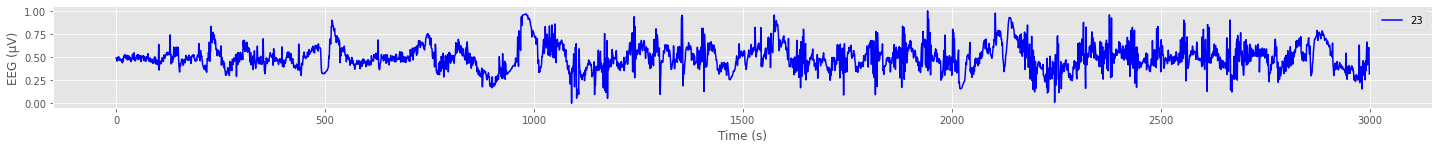

In [9]:
plt.style.use('ggplot')
fig = plt.figure(figsize=[20, 20])

x=10
index = [10]
# np.random.randint(0, x_train.shape[0], x)
for i,v in enumerate(index):
  fig.add_subplot(x,1,i+1)
  plt.plot(x_train[v], label=y_train[v], color='blue')
  plt.ylabel('EEG (μV)')
  plt.xlabel('Time (s)')
  plt.legend(loc="best")
plt.tight_layout()
plt.show()

###WAVENET MODEL

In [10]:
def residual_block(n_filters, kernel_size, x, i):
  tanh_out = Conv1D(n_filters, 
                    kernel_size = kernel_size, 
                    dilation_rate = kernel_size**i, 
                    padding='causal', 
                    name='dilated_conv_%d_tanh' % (kernel_size ** i), 
                    activation='tanh'
                    )(x)
  sigm_out = Conv1D(n_filters, 
                    kernel_size  = kernel_size, 
                    dilation_rate = kernel_size**i, 
                    padding='causal', 
                    name='dilated_conv_%d_sigm' % (kernel_size ** i), 
                    activation='sigmoid'
                    )(x)
  z = Multiply(name='gated_activation_%d' % (i))([tanh_out, sigm_out])
  skip = Conv1D(n_filters, 1, name='skip_%d'%(i))(z)
  res = Add(name='residual_block_%d' % (i))([skip, x])
  return res, skip


In [11]:
def residual_block_b(input, no_of_filters, kernel_size=3):
  x = UpSampling1D(size=2)(input)

  x_short = Conv1D(filters=no_of_filters, kernel_size=1, padding="same")(x)
  x_short = BatchNormalization()(x_short)

  x = Conv1D(filters=no_of_filters, kernel_size=kernel_size, padding="same")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv1D(filters=no_of_filters, kernel_size=kernel_size, padding="same")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x_add = Add()([x_short, x])
  x_out = LeakyReLU(alpha=0.2)(x_add)

  return x_out

In [12]:
def build_model(input_shape, n_filters, dilation_depth, output_shape, kernel_size):    
  i = Input(shape=input_shape, name='original_input')
  x = i
  x_reshaped = Reshape(input_shape + (1,), name='reshaped_input')(x)
  skip_connections = []
  out = Conv1D(n_filters, 2, dilation_rate=1, padding='causal', name='dilated_conv_1')(x_reshaped)
  
  for j in range(1, dilation_depth + 1):
    out, skip = residual_block(n_filters, kernel_size, out, j)
    skip_connections.append(skip)
    
  out = Add(name='skip_connections')(skip_connections)
  out = LeakyReLU(alpha=0.2)(out)
  
  out = Conv1D(16, 3, strides=2, padding='same')(out)
  out = LeakyReLU(alpha=0.2)(out)
  out = BatchNormalization()(out)
  
  out = Conv1D(32, 3, strides=2, padding='same')(out)
  out = LeakyReLU(alpha=0.2)(out)
  out = BatchNormalization()(out)
  
  out = Conv1D(64, 3, strides=2, padding='same')(out)
  out = LeakyReLU(alpha=0.2)(out)
  out = BatchNormalization()(out)

  volume_size = K.int_shape(out)
  out = Flatten()(out)
  out = Dense(output_shape[0])(out)
  encoder = Model(i, out, name="encoder")  
  
  latent_inputs = Input(shape=(output_shape[0],))
  x = Dense(np.prod(volume_size[1:]))(latent_inputs)
  x = Reshape((volume_size[1], volume_size[2]))(x)

  x5 = residual_block_b(x, 64, 3)

  x6 = residual_block_b(x5, 32, 3)

  x7 = residual_block_b(x6, 16, 3)

  o = Conv1D(1, 3, activation='sigmoid', padding='same')(x7)

  decoder = Model(latent_inputs, o, name="decoder")

  autoencoder = Model(i, decoder(encoder(i)), name="autoencoder")
  return (encoder, decoder, autoencoder)

In [13]:
input_shape = (3000, )
output_shape = (512, )
kernel_size = 2
dilation_depth = 6
n_filters = 16
 

(encoder, decoder, autoencoder) = build_model(input_shape, n_filters, dilation_depth, output_shape, kernel_size)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_input (InputLayer)  [(None, 3000)]            0         
_________________________________________________________________
encoder (Functional)         (None, 512)               12305536  
_________________________________________________________________
decoder (Functional)         (None, 3000, 1)           12356481  
Total params: 24,662,017
Trainable params: 24,661,121
Non-trainable params: 896
_________________________________________________________________


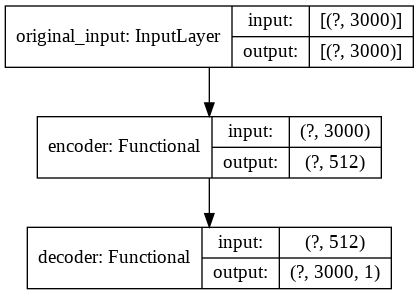

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='./encoder.png', show_shapes=True, show_layer_names=True)
plot_model(decoder, to_file='./decoder.png', show_shapes=True, show_layer_names=True)
plot_model(autoencoder, to_file='./autoencoder.png', show_shapes=True, show_layer_names=True)

In [15]:
INIT_LR = 0.0005
EPOCHS = 15
BATCH_SIZE = 32
STEPS_PER_EPOCH = x_train.shape[0] // BATCH_SIZE
VALIDATION_STEPS = x_val.shape[0] // BATCH_SIZE

def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0

  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

callbacks = [LearningRateScheduler(poly_decay)]

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

def acc(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r_square(y_true, y_pred):
  SS_res =  K.sum(K.square(y_true - y_pred)) 
  SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

opt = Adam(lr=INIT_LR, amsgrad=True)

In [17]:
autoencoder.compile(loss='mse', optimizer=opt, metrics=[acc, 'mae', RootMeanSquaredError(), r_square])

In [18]:
r = autoencoder.fit(
  x_train, x_train,
  validation_data=(x_val, x_val),
  epochs=EPOCHS, batch_size=BATCH_SIZE,
  callbacks=callbacks
)

Epoch 1/15
1883/1883 [==============================] - 143s 76ms/step - loss: 0.0060 - acc: 0.8427 - mae: 0.0522 - root_mean_squared_error: 0.0777 - r_square: 0.7290 - val_loss: 0.0044 - val_acc: 0.8549 - val_mae: 0.0471 - val_root_mean_squared_error: 0.0664 - val_r_square: 0.8028
Epoch 2/15
1883/1883 [==============================] - 141s 75ms/step - loss: 0.0038 - acc: 0.8737 - mae: 0.0413 - root_mean_squared_error: 0.0618 - r_square: 0.8293 - val_loss: 0.0036 - val_acc: 0.8809 - val_mae: 0.0392 - val_root_mean_squared_error: 0.0599 - val_r_square: 0.8396
Epoch 3/15
1883/1883 [==============================] - 141s 75ms/step - loss: 0.0036 - acc: 0.8779 - mae: 0.0397 - root_mean_squared_error: 0.0603 - r_square: 0.8380 - val_loss: 0.0035 - val_acc: 0.8842 - val_mae: 0.0379 - val_root_mean_squared_error: 0.0587 - val_r_square: 0.8460
Epoch 4/15
1883/1883 [==============================] - 141s 75ms/step - loss: 0.0035 - acc: 0.8800 - mae: 0.0389 - root_mean_squared_error: 0.0595 - r

## RESULT ANALYSIS

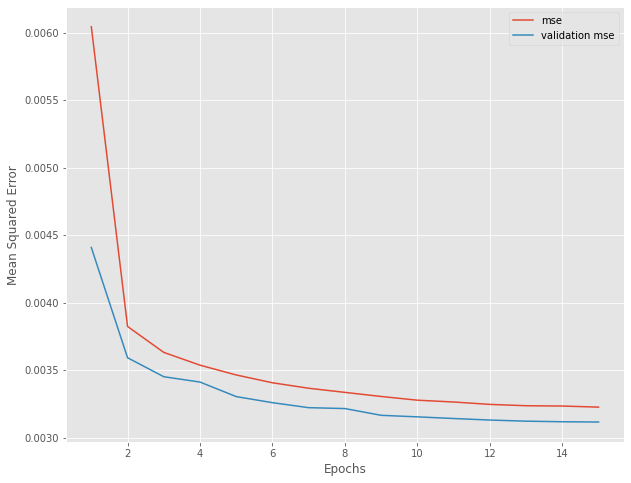

In [19]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(np.arange(1, 16, 1), r.history['loss'], label='mse')
plt.plot(np.arange(1, 16, 1), r.history['val_loss'], label='validation mse')

plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')

plt.savefig('./mse_loss.png')
plt.show()

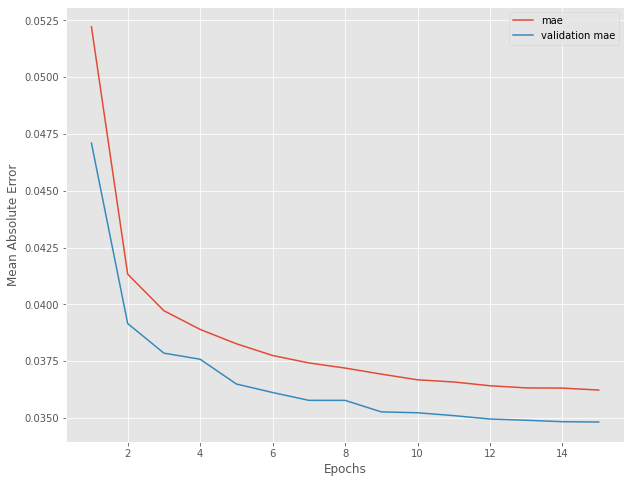

In [20]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(np.arange(1, 16, 1), r.history['mae'], label='mae')
plt.plot(np.arange(1, 16, 1), r.history['val_mae'], label='validation mae')

plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')

plt.savefig('./mae_loss.png')
plt.show()

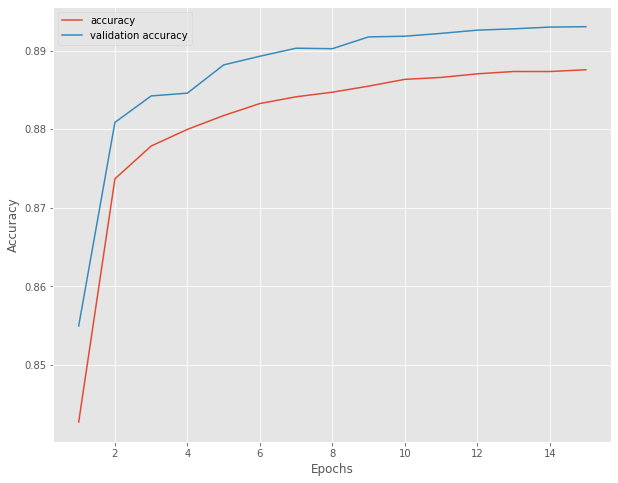

In [21]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(np.arange(1, 16, 1), r.history['acc'], label='accuracy')
plt.plot(np.arange(1, 16, 1), r.history['val_acc'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.savefig('./acc.png')
plt.show()

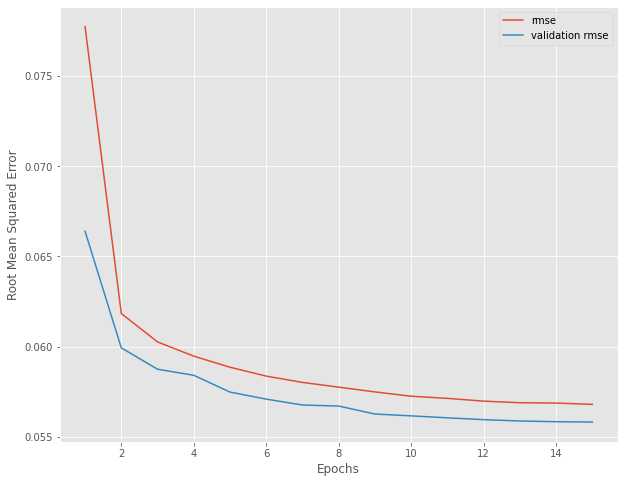

In [22]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(np.arange(1, 16, 1), r.history['root_mean_squared_error'], label='rmse')
plt.plot(np.arange(1, 16, 1), r.history['val_root_mean_squared_error'], label='validation rmse')

plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend(loc='best')

plt.savefig('./rmse_loss.png')
plt.show()

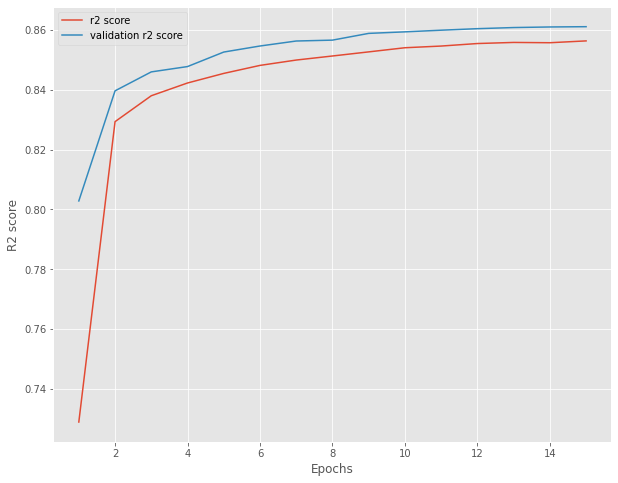

In [23]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(np.arange(1, 16, 1), r.history['r_square'], label='r2 score')
plt.plot(np.arange(1, 16, 1), r.history['val_r_square'], label='validation r2 score')

plt.xlabel('Epochs')
plt.ylabel('R2 score')
plt.legend(loc='best')

plt.savefig('./r2.png')
plt.show()

### TESTING ACCURACY

In [24]:
print(autoencoder.evaluate(x_test, x_test, batch_size=BATCH_SIZE))

673/673 [==============================] - 12s 18ms/step - loss: 0.0030 - acc: 0.8929 - mae: 0.0346 - root_mean_squared_error: 0.0552 - r_square: 0.8636
[0.003044766141101718, 0.8928841948509216, 0.0346367321908474, 0.055179398506879807, 0.8636077642440796]


In [39]:
import time
test = np.reshape(x_test[2], (1, 3000, 1))
t1 = time.time()
output1 = encoder.predict(test)
t2 = time.time()
print("{} seconds".format(round(t2 - t1, 4)))

0.0403 seconds


In [26]:
preds = autoencoder.predict(x_test)
print(preds.shape)

(21520, 3000, 1)


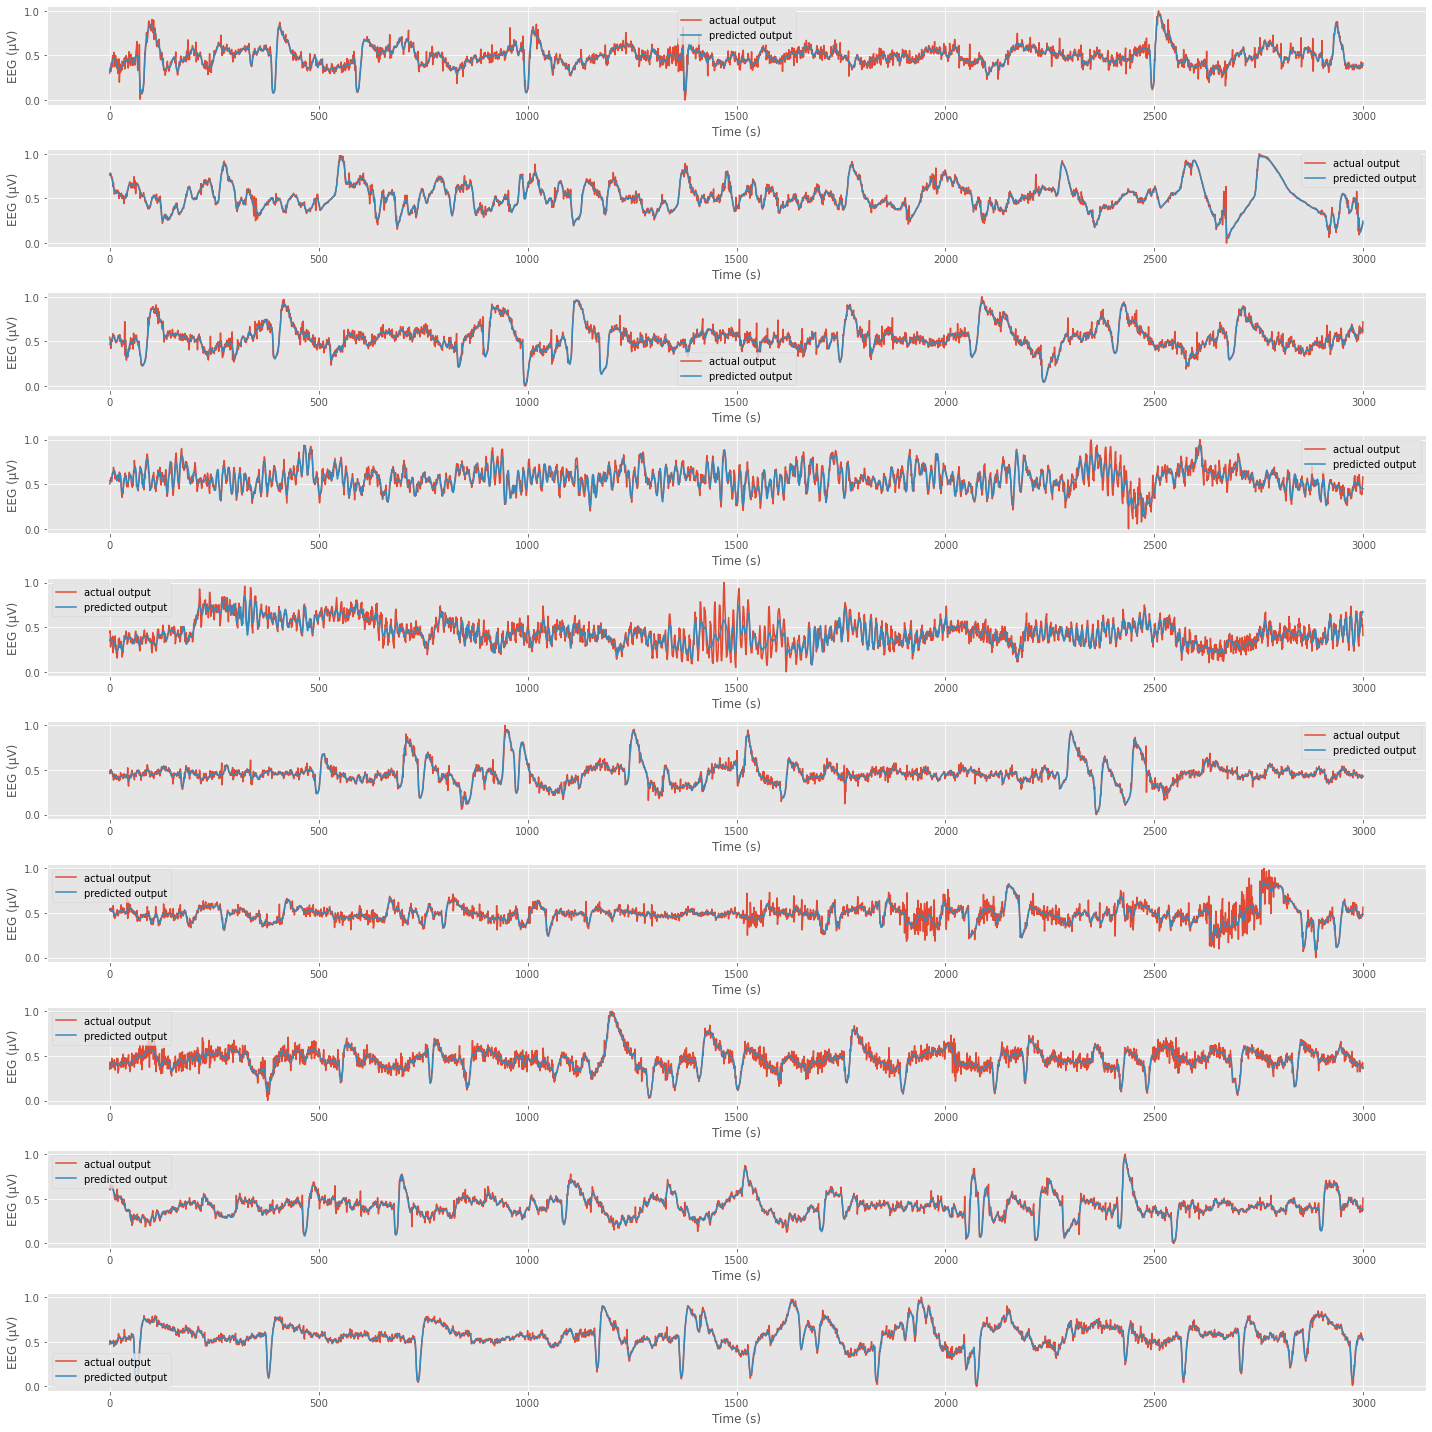

In [35]:
x=10

preds_index = np.random.randint(0, x_test.shape[0], x)

plt.style.use('ggplot')
fig = plt.figure(figsize=[20, 20])

for i,v in enumerate(preds_index):
  fig.add_subplot(x,1,i+1)
  plt.plot(x_test[v], label="actual output")
  plt.plot(preds[v], label="predicted output")
  plt.ylabel('EEG (μV)')
  plt.xlabel('Time (s)')
  plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [28]:
from keras.models import save_model, load_model
save_model(autoencoder, "./autoencoder.h5")
save_model(encoder, "./encoder.h5")
save_model(decoder, "./decoder.h5")

In [37]:
loaded_model = load_model("./encoder.h5", compile=False)

In [40]:
import time
test = np.reshape(x_test[2], (1, 3000, 1))
t1 = time.time()
output2 = loaded_model.predict(test)
t2 = time.time()
print("{} seconds".format(round(t2 - t1, 4)))

0.0418 seconds


In [ ]:
x = output1 - output2
print(output1)

In [47]:
print(y_train[6])
print(x_train.shape)

7
(60256, 3000, 1)


In [56]:
from sklearn.decomposition import PCA

x_tr = np.reshape(x_train, (x_train.shape[0], 3000))

pca = PCA(2)
proj = pca.fit_transform(x_tr)


<Figure size 864x720 with 0 Axes>

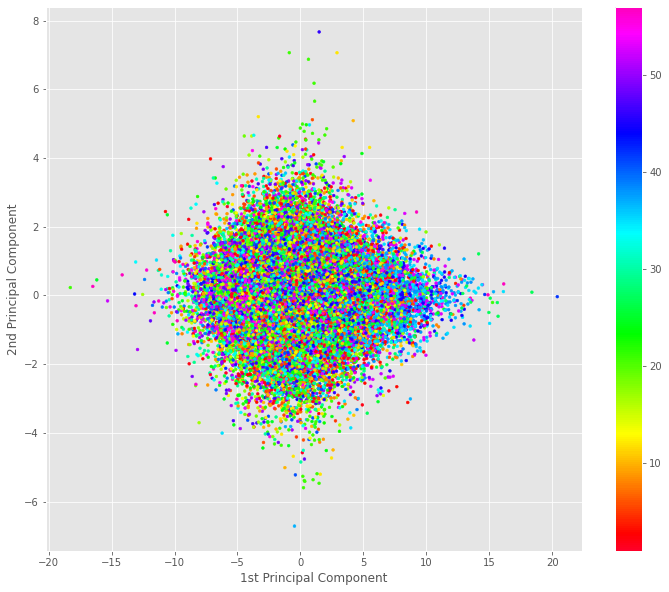

In [64]:
plt.figure(figsize=[12,10])
plt.style.use('ggplot')
plt.scatter(proj[:, 0], proj[:, 1],c=y_train[:], s=8, cmap='gist_rainbow')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.colorbar()
plt.savefig('./x_train_pca.png')
plt.show()

In [65]:
x_vl = np.reshape(x_val, (x_val.shape[0], 3000))

pca = PCA(2)
proj = pca.fit_transform(x_vl)

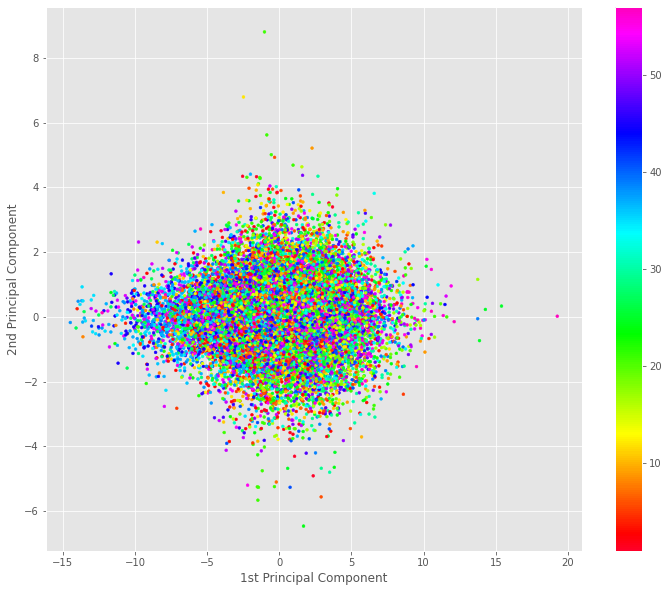

In [66]:
plt.figure(figsize=[12,10])
plt.style.use('ggplot')
plt.scatter(proj[:, 0], proj[:, 1],c=y_val[:], s=8, cmap='gist_rainbow')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.colorbar()
plt.savefig('./x_val_pca.png')
plt.show()

In [67]:
x_te = np.reshape(x_test, (x_test.shape[0], 3000))

pca = PCA(2)
proj = pca.fit_transform(x_te)

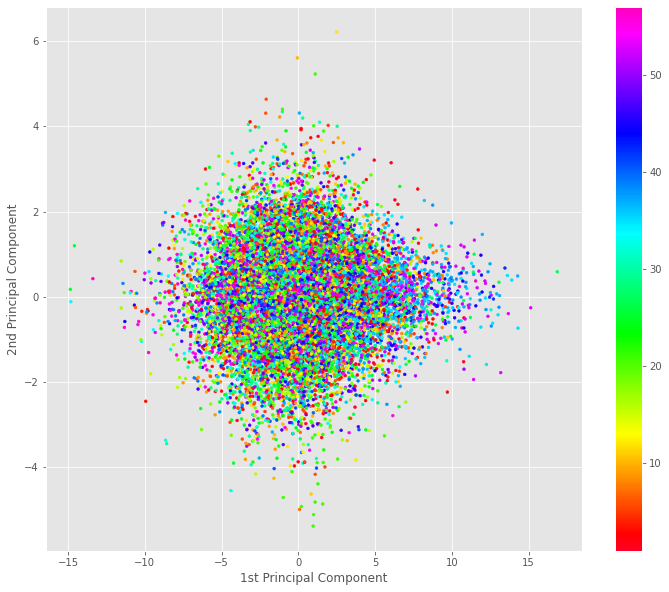

In [68]:
plt.figure(figsize=[12,10])
plt.style.use('ggplot')
plt.scatter(proj[:, 0], proj[:, 1],c=y_test[:], s=8, cmap='gist_rainbow')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.colorbar()
plt.savefig('./x_test_pca.png')
plt.show()

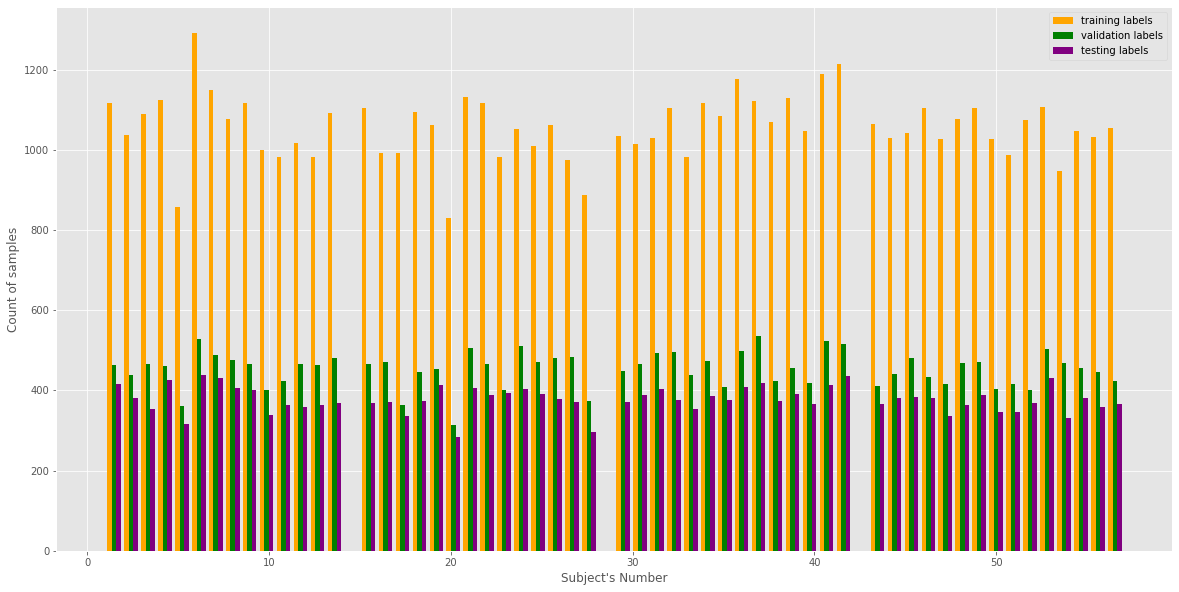

In [83]:
plt.figure(figsize=[20,10])
plt.style.use('ggplot')
hist = plt.hist([y_train, y_val, y_test], color=['orange', 'green', 'purple'], bins=60)
plt.legend(['training labels', 'validation labels', 'testing labels'], loc='best')
plt.xlabel("Subject's Number")
plt.ylabel('Count of samples')
plt.savefig('./histogram.png')
plt.show()